In [25]:
import sys
sys.argv = ['23']

import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import utils

import config.config as cc
from Functions.original.methods.general.generator import Generator
import torch.nn as nn
import torch
from Functions import metrics
import xgboost as xgb
from sampler import sample
import numpy as np
from itertools import combinations
import Functions.evaluation as ev

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Real without expert input

In [26]:
specific_transformer = joblib.load(cc.params['output_scaler'])

In [28]:
train = pd.read_pickle(cc.train_specific)
test = pd.read_pickle(cc.test_specific)
train1 = specific_transformer.inverse_transform(train, keep_ei=False)
test1 = specific_transformer.inverse_transform(test, keep_ei=False)

ev.run_xgboost(train1, test1)

(29.98, 0.1, 0.23, 0.31)

In [36]:
train1.head()

,VehPower,VehAge,DrivAge,Density,BonusMalus,Exposure,EI_Density,EI_DrivAge,EI_BonusMalus1,EI_BonusMalus2,...,Area_2,Area_3,Area_4,Area_5,Area_6,ClaimNb_0.0,ClaimNb_1.0,ClaimNb_2.0,ClaimNb_3.0,ClaimNb_4.0
199985,0.46,-0.92,0.39,1.45,-0.62,0.75,0.06,0.06,0.05,117.43,...,0,0,0,1,0,1,0,0,0,0
419340,1.71,-0.92,-0.96,1.46,-0.62,-0.52,0.06,0.04,0.05,117.43,...,0,0,0,1,0,0,1,0,0,0
489244,-0.78,-0.92,0.32,-0.49,0.14,-1.18,0.05,0.06,0.05,117.43,...,0,1,0,0,0,1,0,0,0,0
581092,0.46,0.75,0.74,-0.51,2.58,0.33,0.05,0.06,0.09,117.43,...,0,1,0,0,0,1,0,0,0,0
114554,1.09,0.38,-1.38,-0.33,2.26,0.58,0.05,0.05,0.08,117.43,...,0,1,0,0,0,0,1,0,0,0


# Bootstrapping

In [39]:
train = pd.read_pickle(cc.train_specific)
test = pd.read_pickle(cc.test_specific)
train1 = specific_transformer.inverse_transform(train, keep_ei=False)
test1 = specific_transformer.inverse_transform(test, keep_ei=False)

train_boot = utils.resample(train1, replace=True, n_samples=500000, random_state=3, stratify=None)
ev.run_xgboost(train_boot, test1)

(30.15, 0.1, 0.23, 0.32)

# Real with expert input

In [31]:
train = pd.read_pickle(cc.train_specific)
test = pd.read_pickle(cc.test_specific)
train1 = specific_transformer.inverse_transform(train, keep_ei=True)
test1 = specific_transformer.inverse_transform(test, keep_ei=True)

ev.run_xgboost(train1, test1)

(30.0, 0.1, 0.23, 0.31)

In [110]:
modelparams = pd.read_csv(cc.paramspath, sep=';').iloc[15:-1]

In [111]:
models_ei = modelparams.set_index('sim_num').T.to_dict()

In [151]:
for key, value in models_ei.items():
    print(f'{key}:')
    try:
        value['losses'] = pd.read_csv(value['output_loss'])
    except FileNotFoundError:
        print(f"Model {key} not trained yet")
        continue
    try:
        value['scaler'] = joblib.load(value['output_scaler'])
    except (ModuleNotFoundError, FileNotFoundError):
        print(f"Scaler for model {key} could not be loaded")
        value['scaler'] = joblib.load('./data/scalers/scaler3.pkl')
    
    model_best = Generator(
    noise_size=int(value['z_size']),
    output_size=cc.metadata['variable_sizes'],
    hidden_sizes=[int(x) for x in value['generator_hidden_sizes'].split(',')],
    bn_decay=value['gen_bn_decay']
    )
    
    model_final = Generator(
    noise_size=int(value['z_size']),
    output_size=cc.metadata['variable_sizes'],
    hidden_sizes=[int(x) for x in value['generator_hidden_sizes'].split(',')],
    bn_decay=value['gen_bn_decay']
    )
    
    try:
        model_best.load_state_dict(torch.load(f"{value['output_generator']}_inbetween", map_location=lambda storage, loc: storage))
        value['generator_best'] = model_best
        train_gan = sample(
                generator=value['generator_best'],
                num_features=cc.metadata['num_features'],
                num_samples= 500000,
                batch_size= 500000,
                noise_size=int(value['z_size'])
        )
        value['sample_best'] = pd.DataFrame(train_gan)
        value['sample_best'] = value['scaler'].inverse_transform(value['sample_best'])
        value['sample_best']['DrivAge'] = value['sample_best']['DrivAge'].astype(int)
        value['sample_final'] = value['sample_final'].loc[value['sample_final']['DrivAge'].between(18, 90)]
        
    except FileNotFoundError:
        print('Did not find between generator')
    model_final.load_state_dict(torch.load(value['output_generator'], map_location=lambda storage, loc: storage))
    value['generator_final'] = model_final
    train_gan = sample(
                generator=value['generator_final'],
                num_features=cc.metadata['num_features'],
                num_samples= 500000,
                batch_size= 500000,
                noise_size=int(value['z_size'])
            )
    value['sample_final'] = pd.DataFrame(train_gan)
    value['sample_final'] = value['scaler'].inverse_transform(value['sample_final'])
    value['sample_final']['DrivAge'] = value['sample_final']['DrivAge'].astype(int)
    value['sample_final'] = value['sample_final'].loc[value['sample_final']['DrivAge'].between(18, 90)]

    train = pd.read_pickle(cc.train_common)
    test = pd.read_pickle(cc.test_common)
    value['train'] = value['scaler'].transform(train)
    value['test'] = value['scaler'].transform(test)
    value['train'] = value['scaler'].inverse_transform(value['train'])
    value['test'] = value['scaler'].inverse_transform(value['test'])    

4.0:
3.0:
1.0:
Model 1.0 not trained yet


In [103]:
train = pd.read_pickle(cc.train_specific)
test = pd.read_pickle(cc.test_specific)

In [ ]:
def make_glms(train, test, base_formula = ''):
    # No Input
    formula0 = "ClaimNb ~ 1"
    formula1 = f"ClaimNb ~ {base_formula}  VehPowerGLM + C(VehAgeGLM, Treatment(reference=2)) + C(DrivAgeGLM, Treatment(reference=5)) + BonusMalusGLM + VehGas + DensityGLM + C(Region, Treatment(reference='R24'))"
    formula2 = f"{formula1} + VehBrand"
    formula3 = f"{formula2} + AreaGLM"

    formulas = [formula0, formula1, formula2, formula3]
    devs = []
    
    for formulaa in formulas:
        glm0 = smf.glm(formula=formulaa, data=train, family=sm.families.Poisson(link=sm.families.links.log()), offset=np.log(train['Exposure'])).fit()
        devs += [metrics.poisson_deviance(glm0.predict(test, offset=np.log(test['Exposure'])), test['ClaimNb'])]
    
    assert min(devs) != devs[0], f'Issue with metrics: {dev}; random model predicts best?!'
    return min(devs)
    

In [ ]:
print(
    
    make_glms(train, test),
    make_glms(train, test, base_formula = 'EI_Density + EI_DrivAge + EI_BonusMalus1 + EI_BonusMalus2 + EI_VehAge +'),
    make_glms(train, test, base_formula = 'GDV_Area + GDV_VehAge + GDV_DrivAge + '),
    make_glms(train, test, base_formula = 'GDV_Area + GDV_VehAge + GDV_DrivAge + EI_Density + EI_DrivAge + EI_BonusMalus1 + EI_BonusMalus2 + EI_VehAge +')
)

In [60]:
train1 = specific.inverse_transform(train)
test1 = specific.inverse_transform(test)

In [40]:
models_ei[4]['sample_best']

NameError: name 'models_ei' is not defined

In [170]:
run_xgboost(models_ei[3]['sample_best'], models_ei[3]['test'])

(34.36056128531707,
 0.10832881675346996,
 0.24304770117183477,
 0.41164807840942924)

In [171]:
run_xgboost(models_ei[4]['sample_best'], models_ei[4]['test'])

(33.49982405512103,
 0.10471609938458648,
 0.2443187661231037,
 0.4578781599980055)

In [172]:
run_xgboost(models_ei[4]['sample_final'], models_ei[4]['test'])

(35.13531592423808,
 0.10643067452542822,
 0.2560946444532043,
 0.5979749799037785)

In [173]:
run_xgboost(models_ei[3]['sample_final'], models_ei[3]['test'])

(38.695160767967565,
 0.10551261753714256,
 0.2560916146684446,
 0.6280656931261911)

In [169]:
run_xgboost(models_ei[3]['train'], models_ei[3]['test'])

(29.98217976197135,
 0.09795535503277099,
 0.23345391626455292,
 0.312967133426957)

<Axes: xlabel='DrivAge'>

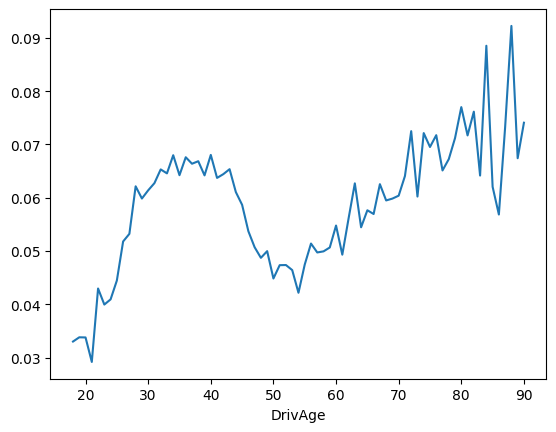

In [157]:
models_ei[3]['sample_final'].groupby('DrivAge')['ClaimNb'].mean().plot()

<Axes: xlabel='DrivAge'>

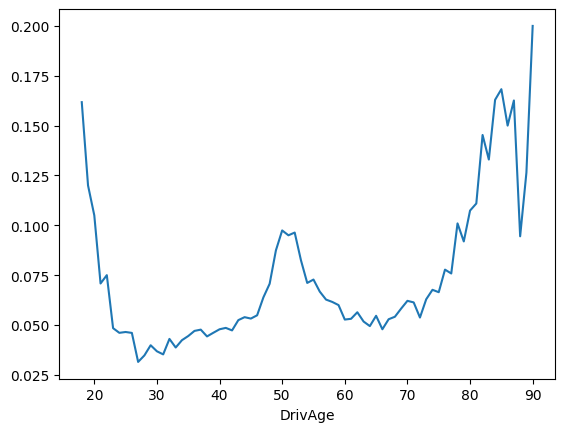

In [155]:
models_ei[4]['sample_final'].groupby('DrivAge')['ClaimNb'].mean().plot()

<Axes: xlabel='DrivAge'>

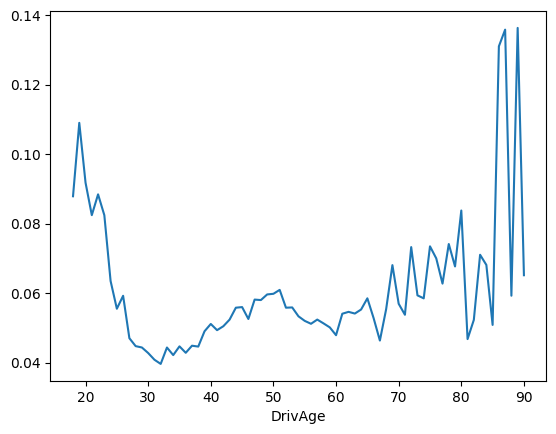

In [149]:
models_ei[4]['train'].groupby('DrivAge')['ClaimNb'].mean().plot()

<Axes: >

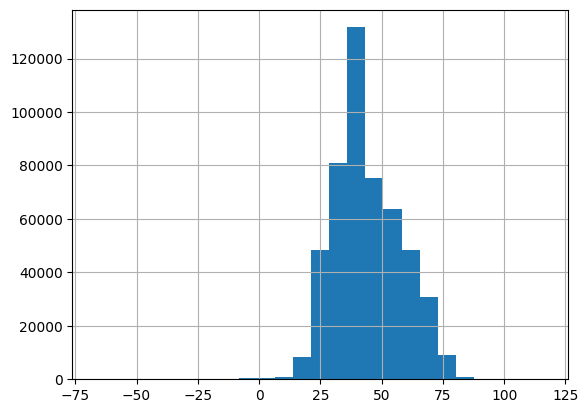

In [137]:
models_ei[4]['train'].groupby('DrivAge')['ClaimNb'].mean().plot()

<Axes: >

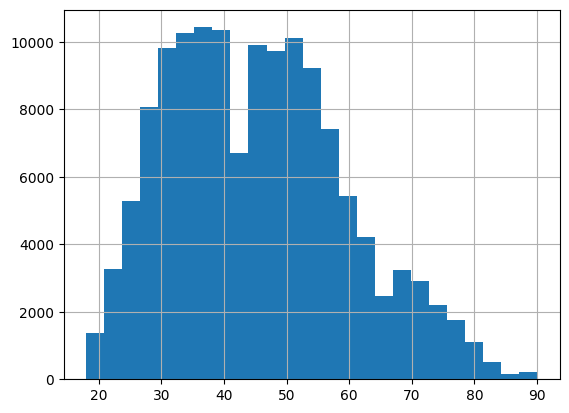

In [124]:
models_ei[4]['test']['DrivAge'].hist(bins=25)

In [64]:
from Functions import metrics
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='count:poisson',
                             n_estimators=1200,
                             max_depth=7,
                             eta=0.025,
                             colsample_bytree=0.8,
                             subsample=0.9,
                             min_child_weight=10,
                             tree_method="hist",
                             random_state=1)

xgb_model.fit(train_gan2.drop(labels='ClaimNb', axis=1), train_gan2['ClaimNb'])

preds2 = xgb_model.predict(test1.drop(labels='ClaimNb', axis=1))

dev_mod2 = metrics.poisson_deviance(preds2, test1['ClaimNb'])
dev_base2 = metrics.poisson_deviance([train_gan2['ClaimNb'].mean()] * len(test1), test1['ClaimNb'])
dev_mae2 = mean_absolute_error(test1['ClaimNb'], preds2)
dev_rmse2 = mean_squared_error(test1['ClaimNb'], preds2) ** 0.5

(dev_mod2, dev_base2, dev_mae2, dev_rmse2)

(43.906325984508264, 32.763202082176704, 0.114846262355297, 0.2603551588748538)

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='count:poisson',
                             n_estimators=1200,
                             max_depth=7,
                             eta=0.025,
                             colsample_bytree=0.8,
                             subsample=0.9,
                             min_child_weight=10,
                             tree_method="hist",
                             random_state=1)

xgb_model.fit(train1.drop(labels='ClaimNb', axis=1), train1['ClaimNb'])

preds0 = xgb_model.predict(test1.drop(labels='ClaimNb', axis=1))

dev_mod0 = metrics.poisson_deviance(preds0, test1['ClaimNb'])
dev_base0 = metrics.poisson_deviance([train1['ClaimNb'].mean()] * len(test1), test1['ClaimNb'])
dev_mae0 = mean_absolute_error(test1['ClaimNb'], preds0)
dev_rmse0 = mean_squared_error(test1['ClaimNb'], preds0) ** 0.5

(dev_mod0, dev_base0, dev_mae0, dev_rmse0)

In [ ]:
metrics_df = pd.DataFrame({
    'Data type': ['Real data', 'Generated', 'Generated with expert input'],
    'Poisson Deviation': [dev_mod0, dev_mod1, dev_mod2],
    'MAE': [dev_mae0, dev_mae1, dev_mae2],
    'RMSE': [dev_rmse0, dev_rmse1, dev_rmse2]
})

metrics_df

In [ ]:
test1['preds0'] = preds0
test1['preds1'] = preds1
test1['preds2'] = preds2

In [ ]:
test1.groupby('DrivAge')['ClaimNb'].mean().plot()

In [ ]:
test1.groupby('DrivAge')['preds0'].mean().plot()

In [ ]:
test1.groupby('DrivAge')['preds1'].mean().plot()

In [ ]:
test1.groupby('DrivAge')['preds2'].mean().plot()

<Axes: xlabel='DrivAge'>

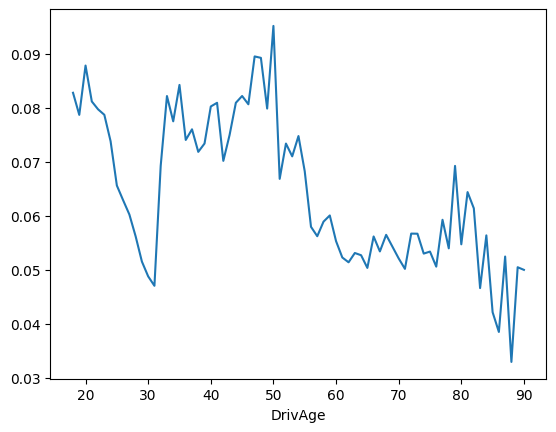

In [77]:
test1.groupby('DrivAge')['preds2'].mean().plot()

In [91]:
# No Input
formula0 = "ClaimNb ~ 1"
formula1 = f"ClaimNb ~   VehPowerGLM + C(VehAgeGLM, Treatment(reference=2)) + C(DrivAgeGLM, Treatment(reference=5)) + BonusMalusGLM + VehGas + DensityGLM + C(Region, Treatment(reference='R24'))"
formula2 = f"{formula1} + VehBrand"
formula3 = f"{formula2} + AreaGLM"



formulas = [formula0, formula1, formula2, formula3]
devs = []

for formulaa in formulas:
    glm0 = smf.glm(formula=formulaa, data=train_gan, family=sm.families.Poisson(link=sm.families.links.log()), offset=np.log(train_gan['Exposure'])).fit()
    devs += [metrics.poisson_deviance(glm0.predict(test, offset=np.log(test['Exposure'])), test['ClaimNb'])]
    print(devs)

[32.91632850254276]
[32.91632850254276, 59.74845410521347]
[32.91632850254276, 59.74845410521347, 59.87506494269026]


TypeError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Object with dtype category cannot perform the numpy op isnan

In [ ]:
Bootstrap(9, n_bootstraps=3, n_train=5, n_test=4, random_state=0)

In [184]:
train1.columns

Index(['ClaimNb', 'VehPower', 'VehAge', 'DrivAge', 'Density', 'BonusMalus',
       'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13',
       'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
       'VehBrand_B5', 'VehBrand_B6', 'VehGas_Regular', 'Region_R21',
       'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26',
       'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
       'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74',
       'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94',
       'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6'],
      dtype='object')